In [1]:
import os
import cv2
import numpy as np

def load_data():
  base_folder = 'iNaturalist'
  toxic_folder = f'{base_folder}/toxic_images'
  nontoxic_folder = f'{base_folder}/nontoxic_images'

  toxic_paths = [os.path.join(dp, f) for dp, dn, filenames  in os.walk(toxic_folder) for f in filenames if os.path.splitext(f)[1] == '.jpg']
  nontoxic_paths = [os.path.join(dp, f) for dp, dn, filenames in os.walk(nontoxic_folder) for f in filenames if os.path.splitext(f)[1] == '.jpg']

  toxic_imgs = [cv2.imread(path) for path in toxic_paths]
  nontoxic_imgs = [cv2.imread(path) for path in nontoxic_paths]

  return toxic_imgs, nontoxic_imgs

data = load_data()


In [2]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

from tensorflow.keras import layers, models

In [3]:
toxic_imgs, nontoxic_imgs = data
IMG_SHAPE = (224, 224, 3)
prepared_toxic_imgs = np.array([cv2.resize(img, IMG_SHAPE[:2]) for img in toxic_imgs])
prepared_nontoxic_imgs = np.array([cv2.resize(img, IMG_SHAPE[:2]) for img in nontoxic_imgs])

print(prepared_toxic_imgs.shape)
print(prepared_nontoxic_imgs.shape)

(1645, 224, 224, 3)
(1815, 224, 224, 3)


In [4]:
toxic_labels = np.array([[1, 0] for _ in range(len(prepared_toxic_imgs))])
nontoxic_labels = np.array([[0, 1] for _ in range(len(prepared_nontoxic_imgs))])

X = np.vstack((prepared_toxic_imgs, prepared_nontoxic_imgs))
y = np.vstack((toxic_labels, nontoxic_labels))

X, y = shuffle(X, y, random_state=42)
y = np.argmax(y, axis=1)

# Split the data into temporary and testing (combined test/validation) sets
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.105, random_state=42)

# Split the temporary set into the actual test and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.12, random_state=42)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_val.shape, y_val.shape)


(2724, 224, 224, 3) (2724,) (364, 224, 224, 3) (364,) (372, 224, 224, 3) (372,)


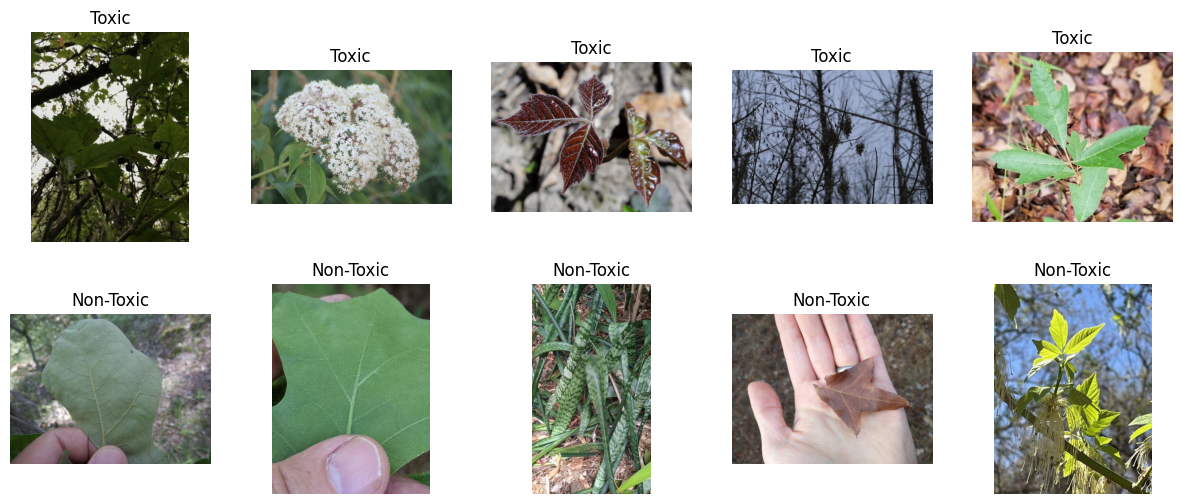

In [5]:
import random
import matplotlib.pyplot as plt

def display_random_images(toxic_imgs, nontoxic_imgs, num_toxic=5, num_nontoxic=5):
    random_toxic_imgs = random.sample(toxic_imgs, num_toxic)
    random_nontoxic_imgs = random.sample(nontoxic_imgs, num_nontoxic)

    plt.figure(figsize=(15, 6))

    for i, img in enumerate(random_toxic_imgs):
        plt.subplot(2, 5, i + 1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title('Toxic')
        plt.axis('off')

    for i, img in enumerate(random_nontoxic_imgs):
        plt.subplot(2, 5, num_toxic + i + 1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title('Non-Toxic')
        plt.axis('off')

    plt.show()

# Use the function to display 5 toxic and 5 non-toxic images
display_random_images(toxic_imgs, nontoxic_imgs, num_toxic=5, num_nontoxic=5)


In [6]:
# Define the CNN model
model = models.Sequential()

# Convolutional layers
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Flatten the output to feed into dense layers
model.add(layers.Flatten())

# Dense layers
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))  # Add dropout for regularization

model.add(layers.Dense(1, activation='sigmoid'))  # Binary classification, so using sigmoid activation

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Display the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 128)       0

2023-12-09 17:26:24.750771: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Max
2023-12-09 17:26:24.750794: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2023-12-09 17:26:24.750799: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2023-12-09 17:26:24.750831: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-09 17:26:24.750845: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [7]:
# Callback to save weights of the best model based on validation accuracy
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='/Users/siddharthlakkoju/Documents/Semester 5/Machine Learning/Project/cnn1/',  # Specify the path where you want to save the weights
    save_weights_only=True,
    save_best_only=True,  
    monitor='val_accuracy',  
    mode='max',  
    verbose=1  
)

history_c1 = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val), callbacks=[checkpoint_callback])

Epoch 1/20


2023-12-09 17:26:25.365266: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


86/86 [==============================] - ETA: 0s - loss: 29.1179 - accuracy: 0.5055

2023-12-09 17:26:29.473785: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_accuracy improved from -inf to 0.56183, saving model to /Users/siddharthlakkoju/Documents/Semester 5/Machine Learning/Project/cnn1/
86/86 [==============================] - 5s 51ms/step - loss: 29.1179 - accuracy: 0.5055 - val_loss: 0.6832 - val_accuracy: 0.5618
Epoch 2/20
85/86 [============================>.] - ETA: 0s - loss: 0.6801 - accuracy: 0.5647
Epoch 2: val_accuracy did not improve from 0.56183
86/86 [==============================] - 4s 44ms/step - loss: 0.6800 - accuracy: 0.5653 - val_loss: 0.6827 - val_accuracy: 0.5296
Epoch 3/20
85/86 [============================>.] - ETA: 0s - loss: 0.7508 - accuracy: 0.5676
Epoch 3: val_accuracy did not improve from 0.56183
86/86 [==============================] - 4s 44ms/step - loss: 0.7504 - accuracy: 0.5675 - val_loss: 0.7065 - val_accuracy: 0.4892
Epoch 4/20
85/86 [============================>.] - ETA: 0s - loss: 0.6633 - accuracy: 0.5798
Epoch 4: val_accuracy did not improve from 0.56183
86/86 [=====================

In [8]:
eval_result = model.evaluate(X_test, y_test)
print(f"Test loss: {eval_result[0]}, Test accuracy: {eval_result[1]}")

12/12 [==============================] - 0s 19ms/step - loss: 7.9748 - accuracy: 0.4643
Test loss: 7.9748358726501465, Test accuracy: 0.4642857015132904


In [10]:
import pickle

# Save the history_c1 object to a file
with open('history_c1.pkl', 'wb') as file:
    pickle.dump(history_c1.history, file)

# Load the history_c1 object from a file
with open('history_c1.pkl', 'rb') as file:
    loaded_history_c1 = pickle.load(file)

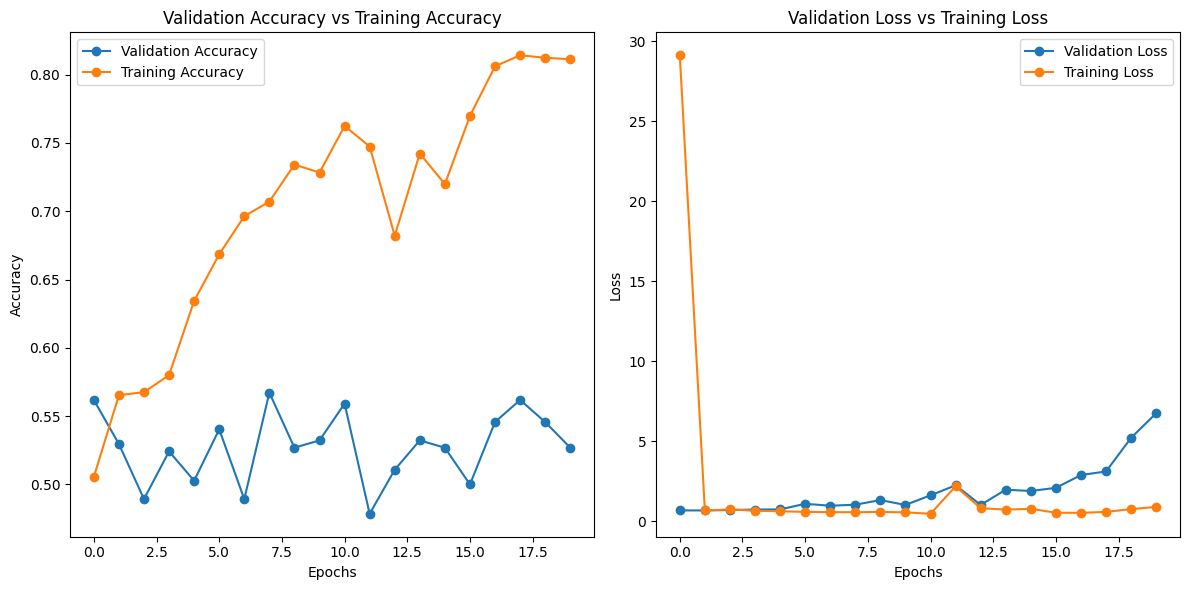

In [11]:
import matplotlib.pyplot as plt

# Assuming you have already trained your model and stored the history in a variable named history_c1
history_c1_dict = history_c1.history

# Plotting validation accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_c1_dict['val_accuracy'], label='Validation Accuracy', marker='o')
plt.plot(history_c1_dict['accuracy'], label='Training Accuracy', marker='o')
plt.title('Validation Accuracy vs Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting validation loss
plt.subplot(1, 2, 2)
plt.plot(history_c1_dict['val_loss'], label='Validation Loss', marker='o')
plt.plot(history_c1_dict['loss'], label='Training Loss', marker='o')
plt.title('Validation Loss vs Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()
